<a href="https://colab.research.google.com/github/tbottelbergs/cv_copy/blob/master/CV_V0.0.8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

# Version History

## V0.0.1 
* One-hot encoding (based on first class)
* Predictions based on softmax (no extra hidden layer of MobileNetV2)
* Optimizer='rmsprop', Loss='categorical_crossentropy'

## V0.0.2
* Added extra hidden layer of 1024 nodes
* Accuracy never rises above 74% (depends on which class is selected as first class)

## V0.0.3
* Added multi-label targets
* Changed output layer to 'sigmoid' activation function
* Changed the loss function to tf.keras.losses.CategoricalCrossentropy(from_logits=True)
* Changed the metric to categorical_accuracy

## V0.0.4
* Changed loss function to tf.nn.sigmoid_cross_entropy_with_logits
-> doesn't make things better

## V0.0.5
* Using TruePositives, TrueNegatives, FalsePositives, FalseNegatives, TopKCategoricalAccuracy(k=1) as metric
* Added fine tuning of last 55 layers of the base model

## V0.0.6
* Split training and test as was done for the VOC dataset
* Removed from_logits = True
* Switched to BinaryCrossentropy instead of CategoricalCrossentropy
* Used Adam optimiser

## V0.0.7
* Using learning rate LR = 1e-5

## V0.0.8
* Doubled the number of epochs to 20
* Rescaled the data to [-1,1] -> did not seem to have a positive effect

Fetch data

In [0]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import random
import tensorflow as tf
from xml.dom import minidom
import matplotlib.pyplot as plt

In [16]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals



File ‘VOCtrainval_11-May-2009.tar’ already there; not retrieving.

Total bytes read: 935536640 (893MiB, 333MiB/s)


To keep in mind:
* In one image, multiple objects can appear (also of different classes)
* Every image has at least one object in it?

In [0]:
voc_root_folder = "/content/VOCdevkit/VOC2009"
trainImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','train.txt')
valImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','val.txt')
trainImageNames = np.loadtxt(trainImageNamesFile, dtype='str')
valImageNames = np.loadtxt(valImageNamesFile, dtype='str')

In [18]:
CLASSES = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow', 'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = dict((c, i) for i, c in enumerate(CLASSES))
idx_to_class = dict((i, c) for i, c in enumerate(CLASSES))
def one_hot_encode(clss):
  encoded = [0 for _ in range(len(CLASSES))]
  for cls in clss:
    encoded[class_to_idx[cls]] = 1
  return encoded
def one_hot_decode(encoded):
  clss = [idx_to_class[idx] for idx, val in enumerate(encoded) if val == 1]
  return clss
a = one_hot_encode(['bicycle', 'bus', 'chair'])
print(a)
print(one_hot_decode(a))

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['bicycle', 'bus', 'chair']


In [0]:
image_folder = os.path.join(voc_root_folder, "JPEGImages")
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def createDataSet(imageNames):
  images = []
  targets = []
  for imageName in imageNames:
    xmlFile = os.path.join(voc_root_folder,'Annotations',imageName + '.xml')
    xml = minidom.parse(xmlFile)
    objectsXml = xml.getElementsByTagName('object')
    objects = []
    image = io.imread(os.path.join(image_folder,imageName + ".jpg"))
    image = (image/127.5) - 1
    image = resize(image, IMG_SHAPE)
    for objectXml in objectsXml:
      object = objectXml.getElementsByTagName('name')[0].firstChild.nodeValue
      if object not in objects:
        objects.append(object)
    #if(len(objects) == 1):
    targets.append(one_hot_encode(objects))
    images.append(image)
  return (images,targets)

In [0]:
trainImages, trainTargets = createDataSet(trainImageNames)
validationImages, validationTargets = createDataSet(valImageNames)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

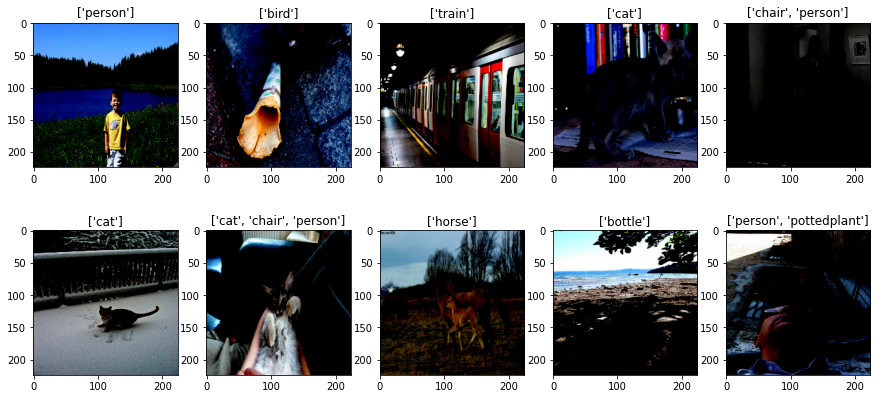

In [21]:
fig=plt.figure(figsize=(15, 7))
for i in range(1,6):
  idx = random.randint(0,len(trainImages))
  fig.add_subplot(2, 5, i)
  plt.imshow((trainImages[idx]+1)*127.5)
  plt.title(one_hot_decode(trainTargets[idx]))
for i in range(6,11):
  idx = random.randint(0,len(validationImages))
  fig.add_subplot(2, 5, i)
  plt.imshow((validationImages[idx]+1)*127.5)
  plt.title(one_hot_decode(validationTargets[idx]))

In [0]:
x_train = np.array(trainImages).astype('float32')
y_train = np.array(trainTargets)
x_val = np.array(validationImages).astype('float32')
y_val = np.array(validationTargets)

In [0]:
BATCH_SIZE = 100
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
validation_batches = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [24]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.trainable = False

In [0]:
@tf.function
def F1(y, y_hat, thresh=0.5):
  print(y_hat)
  return 1

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = tf.keras.layers.Dense(20, activation='sigmoid')
LR = 1e-5
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  predictions
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[F1, tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [27]:
print(len(base_model.layers))

155


In [28]:
print(sum(sum(y_train)))
print(y_train.shape)

5328
(3473, 20)


In [51]:
epochCount = 1
history = model.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Tensor("y_hat:0", shape=(None, 20), dtype=float32)
35/35 [==============================] - 173s 5s/step - loss: 0.5769 - F1: 1.0000 - true_positives_4: 2002.0000 - true_negatives_4: 47351.0000 - false_positives_4: 16781.0000 - false_negatives_4: 3326.0000 - top_k_categorical_accuracy: 0.0898 - val_loss: 0.4763 - val_F1: 1.0000 - val_true_positives_4: 1616.0000 - val_true_negatives_4: 58484.0000 - val_false_positives_4: 7752.0000 - val_false_negatives_4: 3768.0000 - val_top_k_categorical_accuracy: 0.1505


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

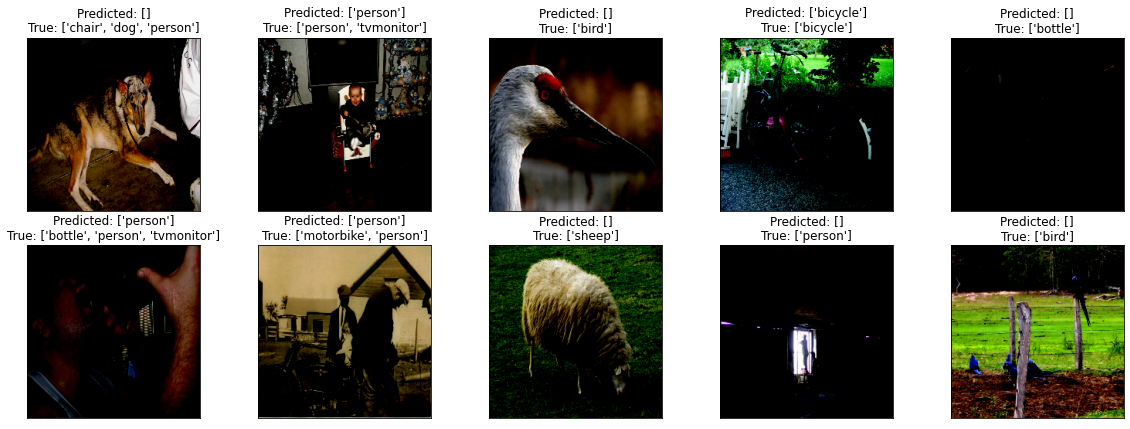

In [30]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_train[idx])
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_val[idx])
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

In [0]:
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Sum(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [33]:
epochCount = 15
history = model.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/20
35/35 [==============================] - 170s 5s/step - loss: 0.1587 - sum: 2182.4583 - true_positives_1: 1975.0000 - true_negatives_1: 63718.0000 - false_positives_1: 414.0000 - false_negatives_1: 3353.0000 - top_k_categorical_accuracy: 0.4653 - val_loss: 0.1371 - val_sum: 2604.8479 - val_true_positives_1: 2616.0000 - val_true_negatives_1: 65932.0000 - val_false_positives_1: 304.0000 - val_false_negatives_1: 2768.0000 - val_top_k_categorical_accuracy: 0.5848
Epoch 2/20
35/35 [==============================] - 171s 5s/step - loss: 0.1376 - sum: 2415.6646 - true_positives_1: 2318.0000 - true_negatives_1: 63902.0000 - false_positives_1: 230.0000 - false_negatives_1: 3010.0000 - top_k_categorical_accuracy: 0.5816 - val_loss: 0.1271 - val_sum: 2850.5630 - val_true_positives_1: 2957.0000 - val_true_negatives_1: 65829.0000 - val_false_positives_1: 407.0000 - val_false_negatives_1: 2427.0000 - val_top_k_categorical_accuracy: 0.6132
Epoch 3/20
35/35 [==============================] 

* categorical_accuracy: the node with the highest output should also be a detected label
* sigmoid_cross_entropy_with_logits

In [34]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [35]:
m = tf.keras.metrics.CategoricalAccuracy() 
_ = m.update_state([[0,0,1,0],[0, 1, 0, 0]], [[0,0.1,0.1,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [36]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
_ = m.update_state([[0,0,1,1],[0, 1, 0, 0]], [[0,0.6,0.5,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [37]:
print(x_val[0:1].shape)

(1, 224, 224, 3)


In [38]:
y_pred = model(x_val[0:1])
y_pred = np.around(y_pred).astype('int')
print(y_pred)
print(one_hot_decode(y_pred[0]))
print(one_hot_decode(y_val[0]))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[]
['tvmonitor']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

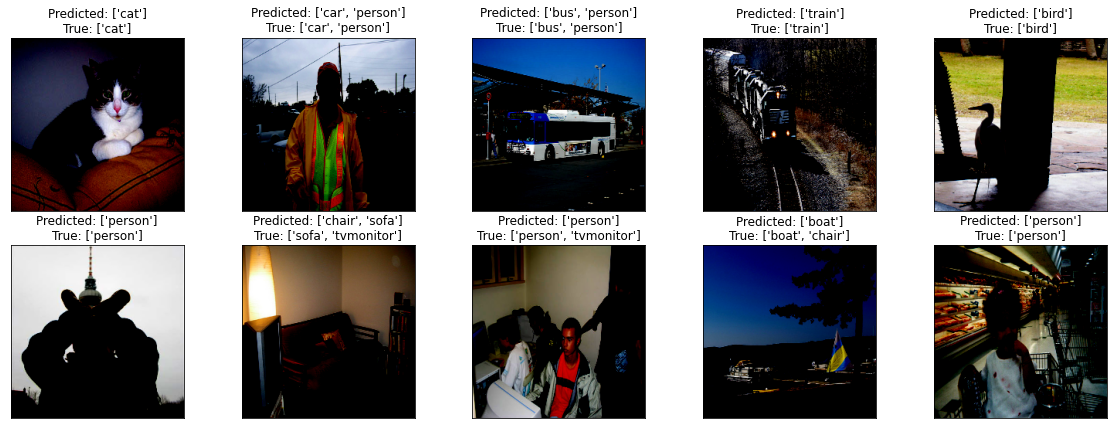

In [39]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)*127.5)
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)*127.5)
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

Some confusion occurs in the algorithm because we are doing multilabel classification instead of detection. The algorithm seems to get confused sometimes because it does not always find the exact area in the picture to which the label belongs. Tipical cases are predicting a person and a bike, when only a bike is visible in the picture, probably because in most pictures these occur together, which might confuse the alogritm. Similarly, a bottle seems to be hard to predict. Probably, because this mostly is a small part of a picture, surrounded by different other objects.